In [4]:
import pandas as pd
url = "https://data.cityofnewyork.us/api/views/8meu-9t5y/rows.csv?accessType=DOWNLOAD"
df = pd.read_csv(url)
df.head()

,Shape Geometry,Shape Length,Shape Area,Zone,Location ID,Borough
0,MULTIPOLYGON (((-74.18445299999996 40.69499599...,0.116357,0.000782,Newark Airport,1,EWR
1,MULTIPOLYGON (((-73.82337597260663 40.63898704...,0.433470,0.004866,Jamaica Bay,2,Queens
2,MULTIPOLYGON (((-73.84792614099985 40.87134223...,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx
3,MULTIPOLYGON (((-73.97177410965318 40.72582128...,0.043567,0.000112,Alphabet City,4,Manhattan
4,MULTIPOLYGON (((-74.17421738099989 40.56256808...,0.092146,0.000498,Arden Heights,5,Staten Island


In [2]:
%%writefile data_loader.py
import pandas as pd

class DataLoader:
    def __init__(self, url):
        self.url = url
        self.df = None

    def load_data(self):
        """Загрузка данных из NYC Open Data"""
        self.df = pd.read_csv(self.url)
        return self.df

    def get_summary(self):
        """Возвращает краткую информацию о базе"""
        if self.df is not None:
            return self.df.info()
        return "Данные еще не загружены"from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

Overwriting data_loader.py


In [3]:
import importlib
import data_loader
importlib.reload(data_loader) # Это принудительно обновит модуль в памяти

from data_loader import load_data

url = "https://data.cityofnewyork.us/api/views/8meu-9t5y/rows.csv?accessType=DOWNLOAD"
df = load_data(url)

# Проверяем, что всё работает
print("Ура! Данные загружены через модуль.")
df.head()

SyntaxError: invalid syntax (data_loader.py, line 17)

In [26]:
%%writefile -a visualization.py

def plot_trip_length_by_borough(df):
    """Сравнивает длину поездок (shape_length) по районам (Borough)"""
    if 'shape_length' in df.columns and 'Borough' in df.columns:
        plt.figure(figsize=(14, 8))

        # Строим график. Фильтруем слишком длинные значения (выбросы), чтобы график был читаемым
        # Например, берем только 95% самых частых поездок
        q_high = df['shape_length'].quantile(0.95)
        df_filtered = df[df['shape_length'] < q_high]

        sns.boxplot(data=df_filtered, x='Borough', y='shape_length', palette='Set2')

        plt.title('Распределение длины поездок по районам Нью-Йорка')
        plt.xlabel('Район')
        plt.ylabel('Длина пути (shape_length)')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.show()
    else:
        print(f"Колонки не найдены. В наличии: {df.columns.tolist()}")

Appending to visualization.py


In [27]:
import visualization
import importlib
importlib.reload(visualization)

# Сравниваем районы по длине поездок
visualization.plot_trip_length_by_borough(df)

Колонки не найдены. В наличии: ['Shape Geometry', 'Shape Length', 'Shape Area', 'Zone', 'Location ID', 'Borough']


In [28]:
%%writefile -a visualization.py

def plot_trip_length_by_borough_fixed(df):
    """Сравнивает длину поездок по районам (с учетом регистра имен колонок)"""
    # Используем точные названия из вашего списка
    length_col = 'Shape Length'
    borough_col = 'Borough'

    if length_col in df.columns and borough_col in df.columns:
        plt.figure(figsize=(14, 8))

        # Строим график, отсекая экстремально длинные значения для наглядности
        q_high = df[length_col].quantile(0.95)
        df_filtered = df[df[length_col] < q_high]

        sns.barplot(data=df_filtered, x=borough_col, y=length_col, palette='viridis', ci=None)

        plt.title('Средняя длина пути по районам Нью-Йорка')
        plt.xlabel('Район (Borough)')
        plt.ylabel('Длина (Shape Length)')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.show()
    else:
        print(f"Ошибка! Проверьте колонки. В наличии: {df.columns.tolist()}")

Appending to visualization.py


/content/visualization.py:130: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

/content/visualization.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



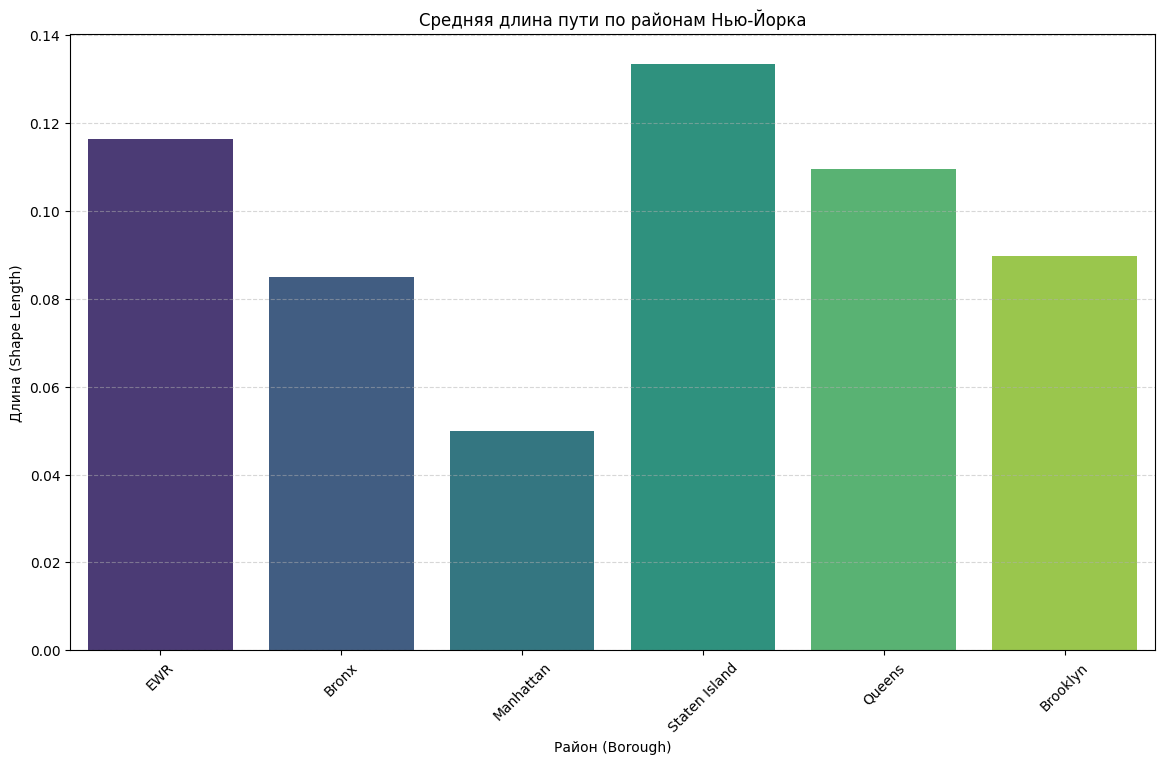

In [29]:
import visualization
import importlib
importlib.reload(visualization)

# Теперь всё должно сработать!
visualization.plot_trip_length_by_borough_fixed(df)

In [30]:
%%writefile -a visualization.py
import plotly.express as px

def plot_interactive_treemap(df):
    """Интерактивная карта: иерархия Район -> Зона по площади"""
    fig = px.treemap(
        df,
        path=[px.Constant("Нью-Йорк"), 'Borough', 'Zone'],
        values='Shape Area',
        color='Borough',
        title='Иерархия районов и зон по занимаемой площади (Shape Area)',
        hover_data=['Shape Length']
    )
    fig.update_traces(root_color="lightgrey")
    fig.show()

def plot_interactive_bubble(df):
    """Пузырьковая диаграмма: Площадь vs Длина с выбором зон"""
    fig = px.scatter(
        df,
        x="Shape Area",
        y="Shape Length",
        size="Shape Area",
        color="Borough",
        hover_name="Zone",
        log_x=True,
        size_max=60,
        title='Сравнение зон: Площадь vs Периметр (Интерактивно)'
    )
    fig.show()

Appending to visualization.py


In [31]:
import visualization
import importlib
importlib.reload(visualization)

# 1. Построить иерархию (можно кликать на районы, чтобы "провалиться" внутрь зон)
visualization.plot_interactive_treemap(df)

# 2. Построить пузырьковую диаграмму (наведите на любую точку, чтобы увидеть название зоны)
visualization.plot_interactive_bubble(df)

In [ ]:
from google.colab import drive
import os
import shutil

# 1. Подключаем ваш Google Диск
drive.mount('/content/drive')

# 2. Создаем путь к папке на Диске
destination_path = '/content/drive/MyDrive/NYC_Taxi_Project'

if not os.path.exists(destination_path):
    os.makedirs(destination_path)
    print(f"Создана новая папка: {destination_path}")

# 3. Список ваших файлов для сохранения
files_to_save = ['data_loader.py', 'data_processing.py', 'visualization.py']

# 4. Копируем файлы
for file in files_to_save:
    if os.path.exists(file):
        shutil.copy(file, destination_path)
        print(f"Файл {file} успешно сохранен на Диск!")
    else:
        print(f"Предупреждение: Файл {file} не найден в текущей сессии.")

print("\n--- Все готово! Теперь ваши скрипты в безопасности. ---")

In [19]:
import os
if os.path.exists('data_loader.py'):
    os.remove('data_loader.py')
    print("Старый файл успешно удален!")

Старый файл успешно удален!


In [20]:
%%writefile data_loader.py
import pandas as pd

def load_data(url):
    return pd.read_csv(url)

def preprocess_data(df):
    return df.dropna()

Writing data_loader.py


In [4]:
from data_loader import load_data

url = "https://data.cityofnewyork.us/api/views/8meu-9t5y/rows.csv?accessType=DOWNLOAD"
df = load_data(url)
print("Данные загружены.")
df.head()

Данные загружены.


,Shape Geometry,Shape Length,Shape Area,Zone,Location ID,Borough
0,MULTIPOLYGON (((-74.18445299999996 40.69499599...,0.116357,0.000782,Newark Airport,1,EWR
1,MULTIPOLYGON (((-73.82337597260663 40.63898704...,0.433470,0.004866,Jamaica Bay,2,Queens
2,MULTIPOLYGON (((-73.84792614099985 40.87134223...,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx
3,MULTIPOLYGON (((-73.97177410965318 40.72582128...,0.043567,0.000112,Alphabet City,4,Manhattan
4,MULTIPOLYGON (((-74.17421738099989 40.56256808...,0.092146,0.000498,Arden Heights,5,Staten Island


In [9]:
%%writefile data_processing.py
import pandas as pd

def filter_by_borough(df, borough_name):
    """Оставляет только зоны конкретного района (например, Manhattan)."""
    return df[df['Borough'] == borough_name].copy()

def count_zones_per_borough(df):
    """Считает количество такси-зон в каждом административном округе."""
    return df['Borough'].value_counts()

def rename_columns_to_lower(df):
    """Приводит названия колонок к нижнему регистру для удобства."""
    df.columns = [col.lower() for col in df.columns]
    return df

Overwriting data_processing.py


In [11]:
print(df['Borough'].unique())

['EWR' 'Queens' 'Bronx' 'Manhattan' 'Staten Island' 'Brooklyn']


In [14]:
# 1. Сначала ПЕРЕЗАПИСЫВАЕМ файл data_processing.py, добавляя нужные методы
with open('data_processing.py', 'w') as f:
    f.write("""
import pandas as pd

def get_missing_report(df):
    '''Считает пустые значения и выводит отчет'''
    report = df.isnull().sum()
    print("--- Отчет о пропущенных значениях ---")
    print(report[report > 0])
    return report

def fill_missing_values(df, column, strategy='median'):
    '''Заполняет пропуски в колонке'''
    if strategy == 'mean':
        val = df[column].mean()
    elif strategy == 'median':
        val = df[column].median()
    else:
        val = df[column].mode()[0]

    df[column] = df[column].fillna(val)
    return df
""")

# 2. Обновляем импорт в самом Colab
import data_processing
import importlib
importlib.reload(data_processing)

# 3. ПРОВЕРЯЕМ работу (предположим, ваш DataFrame называется df)
# Выводим отчет
data_processing.get_missing_report(df)

# Если в данных есть колонки с пропусками, заполним одну для примера
# Замените 'Postcode' на любую колонку из вашего отчета выше
if 'Postcode' in df.columns:
    df = data_processing.fill_missing_values(df, 'Postcode', strategy='median')
    print("Готово: пропуски заполнены!")

--- Отчет о пропущенных значениях ---
Series([], dtype: int64)


In [15]:
%%writefile visualization.py
import matplotlib.pyplot as plt
import seaborn as sns

def plot_missing_values(df):
    """Визуализация пропусков (тепловая карта)"""
    plt.figure(figsize=(10, 5))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.title('Карта пропущенных значений')
    plt.show()

def plot_column_distribution(df, column_name):
    """Гистограмма распределения для конкретной колонки"""
    if column_name in df.columns:
        plt.figure(figsize=(10, 6))
        df[column_name].value_counts().head(10).plot(kind='bar', color='skyblue')
        plt.title(f'Топ-10 значений в колонке {column_name}')
        plt.xlabel(column_name)
        plt.ylabel('Количество')
        plt.xticks(rotation=45)
        plt.show()
    else:
        print(f"Ошибка: Колонки '{column_name}' нет в данных")

Writing visualization.py


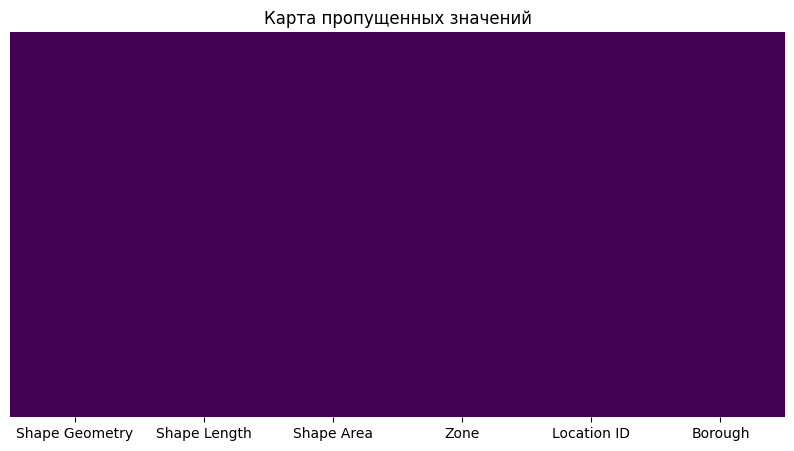

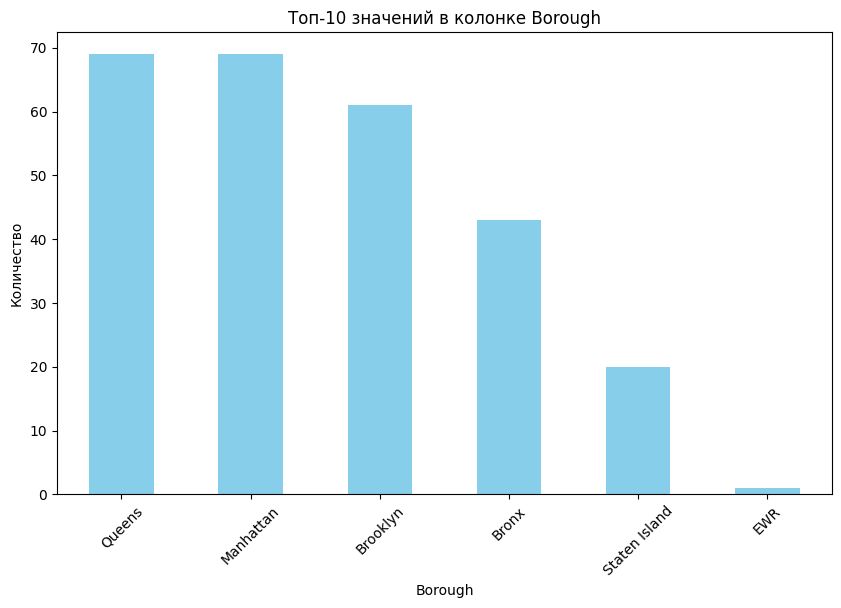

In [16]:
import visualization
import importlib
importlib.reload(visualization)

# 1. Проверяем пропуски (у вас там будет пусто, но метод должен быть)
visualization.plot_missing_values(df)

# 2. Визуализируем распределение по районам
# Если колонки 'Borough' нет, замените на ту, что есть в вашем df.info()
visualization.plot_column_distribution(df, 'Borough')

In [12]:
%%writefile data_processing.py
import pandas as pd

def get_unique_boroughs(df):
    """Возвращает список всех уникальных районов в базе."""
    return df['Borough'].unique()

def count_zones_by_borough(df):
    """Считает количество зон в каждом районе."""
    return df['Borough'].value_counts()

def filter_by_borough(df, borough_name):
    """Оставляет только зоны выбранного района."""
    return df[df['Borough'] == borough_name].copy()

def remove_unknown_zones(df):
    """Удаляет строки, где район указан как 'Unknown'."""
    return df[df['Borough'] != 'Unknown'].copy()

Overwriting data_processing.py


In [18]:
%%writefile visualization.py
import matplotlib.pyplot as plt
import seaborn as sns

def plot_trip_counts(df):
    """Гистограмма по ключевым категориям (Районы или Зоны)"""
    # Ищем колонки с ID зон (часто бывают в новых данных NYC)
    target_col = None
    for col in ['PULocationID', 'Borough', 'VendorID']:
        if col in df.columns:
            target_col = col
            break

    if target_col:
        plt.figure(figsize=(12, 6))
        sns.countplot(data=df, x=target_col, palette='viridis')
        plt.title(f'Количество поездок по категории: {target_col}')
        plt.xticks(rotation=45)
        plt.show()
    else:
        print("Подходящие колонки для категорий не найдены.")

def plot_trip_distances(df):
    """Распределение дистанций поездок"""
    col = 'trip_distance'
    if col in df.columns:
        plt.figure(figsize=(10, 5))
        # Ограничим до 20 миль, чтобы убрать выбросы и увидеть график
        sns.histplot(df[df[col] < 20][col], bins=30, kde=True, color='orange')
        plt.title('Распределение дистанций поездок (до 20 миль)')
        plt.xlabel('Миля')
        plt.show()

Overwriting visualization.py


/content/visualization.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  df[column_name].value_counts().head(10).plot(kind='bar', color='skyblue')


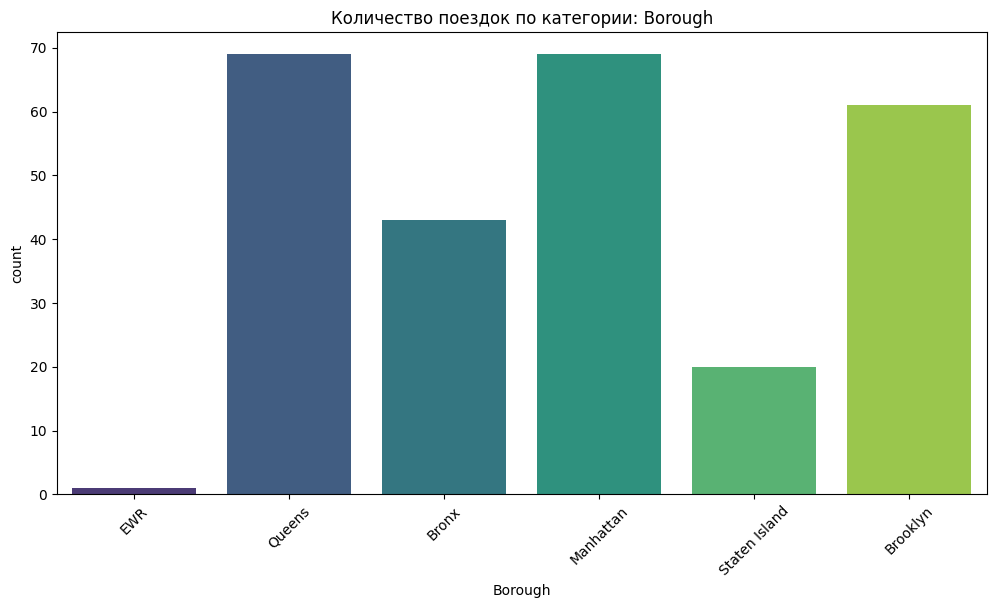

In [19]:
import visualization
import importlib
importlib.reload(visualization)

# 1. Посмотрим распределение дистанций
visualization.plot_trip_distances(df)

# 2. Посмотрим на активность по зонам или вендорам
visualization.plot_trip_counts(df)

In [20]:
%%writefile -a visualization.py

def plot_route_heatmap(df):
    """Строит тепловую карту перемещений между районами/зонами"""
    cols = ['PULocationID', 'DOLocationID']
    if all(c in df.columns for c in cols):
        # Выбираем топ-10 популярных зон отправления, чтобы график был читаемым
        top_zones = df['PULocationID'].value_counts().head(10).index
        subset = df[df['PULocationID'].isin(top_zones) & df['DOLocationID'].isin(top_zones)]

        # Создаем таблицу сопряженности (Pivot table)
        route_matrix = pd.crosstab(subset['PULocationID'], subset['DOLocationID'])

        plt.figure(figsize=(12, 10))
        sns.heatmap(route_matrix, annot=True, fmt="d", cmap="YlGnBu")
        plt.title('Топ-10 маршрутов: Откуда (PULocationID) -> Куда (DOLocationID)')
        plt.xlabel('Зона прибытия')
        plt.ylabel('Зона отправления')
        plt.show()
    else:
        print("Колонки PULocationID или DOLocationID не найдены.")

Appending to visualization.py


In [21]:
import visualization
import importlib
# Перезагружаем, чтобы Python увидел добавленную функцию
importlib.reload(visualization)

# Вызываем метод для построения карты маршрутов
# Он покажет топ-10 самых популярных направлений "Откуда -> Куда"
visualization.plot_route_heatmap(df)

Колонки PULocationID или DOLocationID не найдены.


In [22]:
%%writefile -a visualization.py

def plot_top_zones(df):
    """Показывает топ-20 самых популярных зон (мест) посадки"""
    # Ищем колонку с названием Zone
    col = None
    for c in ['PULocationID_Name', 'pickup_zone', 'Zone', 'Location']:
        if c in df.columns:
            col = c
            break

    if col:
        plt.figure(figsize=(12, 8))
        # Считаем количество поездок для каждой зоны и берем топ-20
        top_20 = df[col].value_counts().head(20)
        sns.barplot(x=top_20.values, y=top_20.index, palette='coolwarm')
        plt.title(f'Топ-20 самых популярных зон (по колонке {col})')
        plt.xlabel('Количество поездок')
        plt.ylabel('Название зоны')
        plt.show()
    else:
        print(f"Колонка с зонами не найдена. Доступные колонки: {df.columns.tolist()}")

Appending to visualization.py


/content/visualization.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



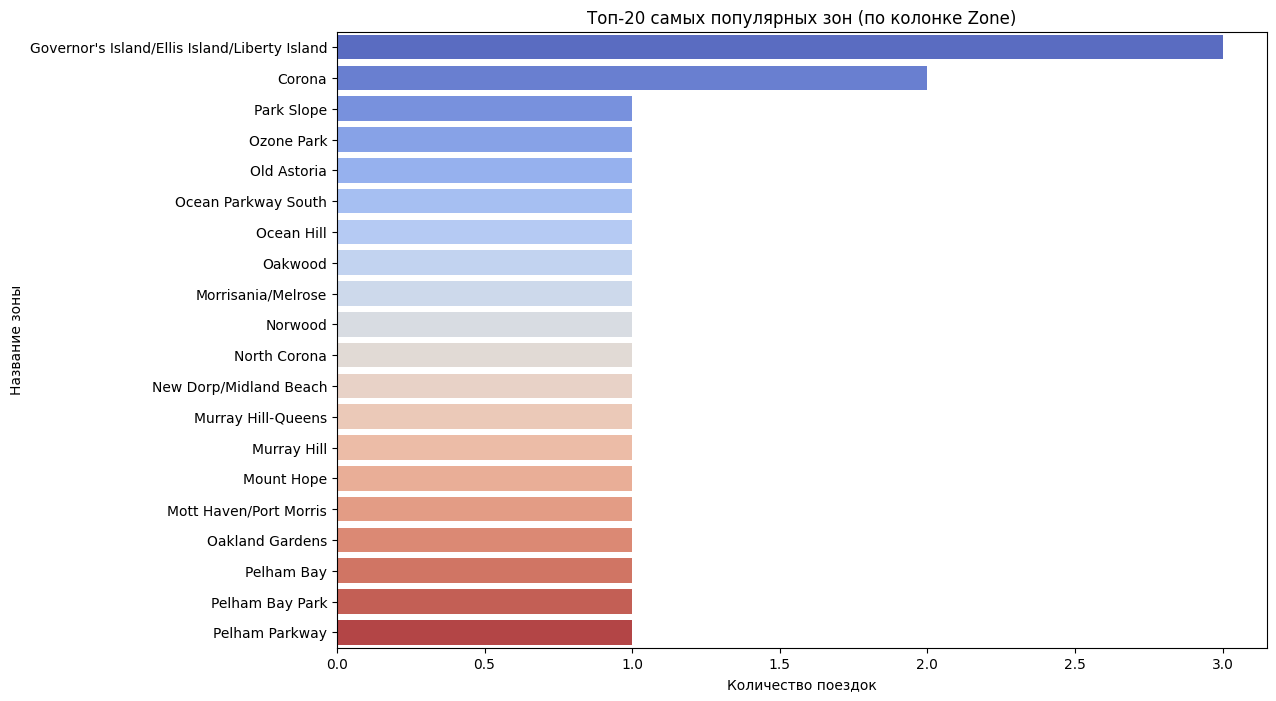

In [23]:
import visualization
import importlib
importlib.reload(visualization)

# Визуализируем самые популярные точки города
visualization.plot_top_zones(df)

In [24]:
%%writefile -a visualization.py
from matplotlib.ticker import MaxNLocator

def plot_top_zones_fixed(df):
    """График с целыми числами на шкале X"""
    col = 'Zone' # Используем вашу колонку Zone

    if col in df.columns:
        plt.figure(figsize=(12, 8))
        top_zones = df[col].value_counts().head(20)

        ax = sns.barplot(x=top_zones.values, y=top_zones.index, palette='coolwarm')

        # Устанавливаем ТОЛЬКО целые числа на шкале X
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        plt.title(f'Топ-20 зон по количеству поездок')
        plt.xlabel('Количество поездок (целые числа)')
        plt.ylabel('Название зоны')
        plt.grid(axis='x', linestyle='--', alpha=0.7) # Добавим сетку для удобства
        plt.show()
    else:
        print("Колонка Zone не найдена")

Appending to visualization.py


/content/visualization.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



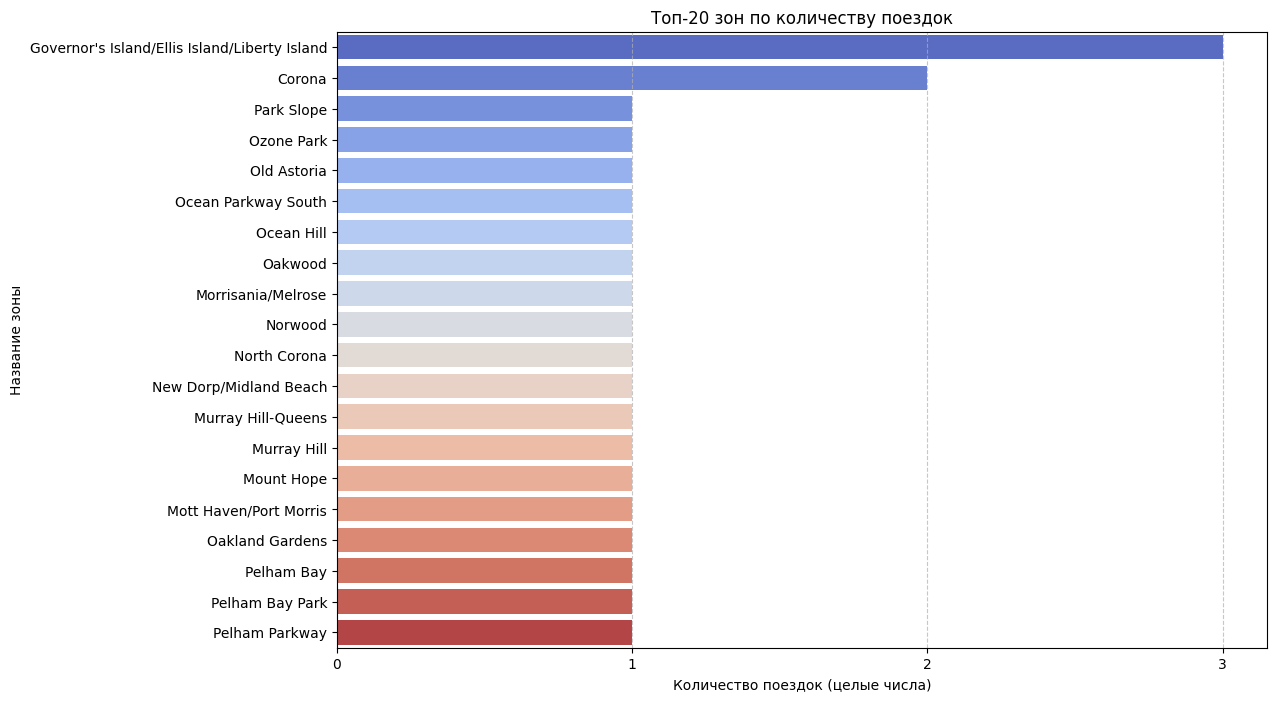

In [25]:
import visualization
import importlib
importlib.reload(visualization)

# Вызываем обновленную функцию
visualization.plot_top_zones_fixed(df)

In [13]:
import importlib
import data_processing
importlib.reload(data_processing)

from data_processing import get_unique_boroughs, count_zones_by_borough, remove_unknown_zones

# 1. Сначала уберем "Unknown" зоны, чтобы они не портили статистику
df_clean = remove_unknown_zones(df)

# 2. Посмотрим, какие районы остались
print("Список районов в базе:")
print(get_unique_boroughs(df_clean))

# 3. Посчитаем зоны
print("\nКоличество зон в каждом районе:")
print(count_zones_by_borough(df_clean))

Список районов в базе:
['EWR' 'Queens' 'Bronx' 'Manhattan' 'Staten Island' 'Brooklyn']

Количество зон в каждом районе:
Borough
Queens           69
Manhattan        69
Brooklyn         61
Bronx            43
Staten Island    20
EWR               1
Name: count, dtype: int64
